In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
import scipy.stats
from scipy.interpolate import make_smoothing_spline
from sklearn.preprocessing import robust_scale
from sklearn.preprocessing import RobustScaler

In [29]:
path = '../tmp'
ticker = '8035'
date = '2024-06-21'
pkl = '%s/%s_%s.pkl' % (path, ticker, date)
df = pd.read_pickle(pkl)
df

,Price
2024-06-21 09:00:05,34820.0
2024-06-21 09:00:11,34820.0
2024-06-21 09:00:17,34780.0
2024-06-21 09:00:24,34750.0
2024-06-21 09:00:29,34800.0
...,...
2024-06-21 14:59:37,34920.0
2024-06-21 14:59:45,34920.0
2024-06-21 14:59:52,34910.0
2024-06-21 14:59:57,34940.0


In [30]:
date_str = str(df.index[0].date())
t_start_1 = pd.to_datetime(date_str + ' 09:00:00')
t_start_2 = pd.to_datetime(date_str + ' 10:00:00')
t_mid = pd.to_datetime(date_str + ' 12:00:00')
print(type(t_mid))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [31]:
df1 = df.loc[df.index[df.index < t_mid]]
df2 = df.loc[df.index[df.index > t_mid]]

In [32]:
df11 = df1.copy()
df11.index = [(t - t_start_1).total_seconds() for t in df1.index]
df11

,Price
5.0,34820.0
11.0,34820.0
17.0,34780.0
24.0,34750.0
29.0,34800.0
...,...
8970.0,34650.0
8977.0,34650.0
8985.0,34650.0
8990.0,34650.0


In [33]:
df21 = df2.copy()
df21.index = [(t - t_start_2).total_seconds() for t in df2.index]
df21

,Price
9003.0,34670.0
9009.0,34670.0
9014.0,34670.0
9020.0,34670.0
9027.0,34660.0
...,...
17977.0,34920.0
17985.0,34920.0
17992.0,34910.0
17997.0,34940.0


In [34]:
df3 = pd.concat([df11, df21])
df3

,Price
5.0,34820.0
11.0,34820.0
17.0,34780.0
24.0,34750.0
29.0,34800.0
...,...
17977.0,34920.0
17985.0,34920.0
17992.0,34910.0
17997.0,34940.0


In [35]:
dict_data = dict()
n = len(df3)
for idx in range(n):
    series = df3.iloc[idx]
    value = series.iloc[0]
    key = series.name
    dict_data[key] = value

In [36]:
df0 = pd.DataFrame({'Price': dict_data.values()}, index=dict_data.keys())
df0

,Price
5.0,34820.0
11.0,34820.0
17.0,34780.0
24.0,34750.0
29.0,34800.0
...,...
17977.0,34920.0
17985.0,34920.0
17992.0,34910.0
17997.0,34940.0


In [37]:
x = np.array(df0.index)
# y = scipy.stats.zscore(df0['Price'])
y = np.array([y for y in robust_scale(df0['Price'])])
y

array([0.63636364, 0.63636364, 0.45454545, ..., 1.04545455, 1.18181818,
       1.09090909])

In [45]:
t_start_0 = 0
t_end_0 = 18000
t_interval_0 = 10

spl = make_smoothing_spline(x, y)
xs = np.linspace(t_start_0, t_end_0, int((t_end_0 - t_start_0) / t_interval_0))
len(xs)

1800

In [46]:
# _____________________________________________________________________
# Integrals for Morning and Afternoon
count = 0
sum_morning = 0
sum_afternoon = 0
for h in spl(xs):
    if count < len(xs) / 2:
        sum_morning += h
    else:
        sum_afternoon += h
    count += 1
print('Area = %d, %d' % (round(sum_morning), round(sum_afternoon)))

Area = -314, 428


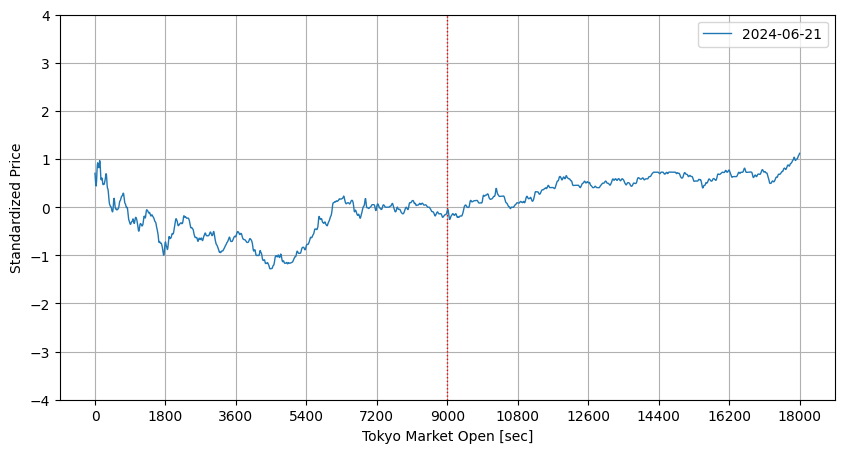

In [47]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots()

ax.axvline(x=9000, linestyle='dotted', lw=1, c='red')

ax.set_xlabel('Tokyo Market Open [sec]')
ax.set_ylabel('Standardized Price')

ax.xaxis.set_ticks(np.arange(0, 18001, 1800))
ax.set_ylim(-4, 4)

#ax.scatter(x, y, s=1, c='gray')
ax.plot(xs, spl(xs), lw=1, label=date)
ax.grid()
ax.legend(loc='best')

plt.show()

# Calculate median and IQR for scaling

In [107]:
y_raw = np.array(df0['Price'])
y_median = np.median(y_raw)
iqr = np.subtract(*np.percentile(y_raw, [75, 25]))
print(y_median, iqr)

33580.0 140.0


In [108]:
y = np.array([(v - y_median) / iqr for v in y_raw])
y

array([ 4.92857143,  5.64285714,  5.07142857, ..., -0.85714286,
       -0.78571429, -0.28571429])

In [109]:
spl = make_smoothing_spline(x, y)
xs = np.linspace(t_start_0, t_end_0, int((t_end_0 - t_start_0) / t_interval_0))
type(spl(xs))

numpy.ndarray

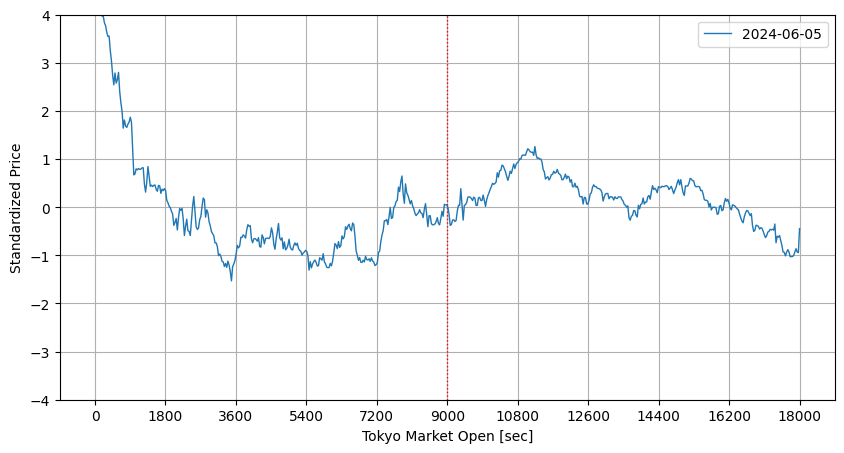

In [110]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots()

ax.axvline(x=9000, linestyle='dotted', lw=1, c='red')

ax.set_xlabel('Tokyo Market Open [sec]')
ax.set_ylabel('Standardized Price')

ax.xaxis.set_ticks(np.arange(0, 18001, 1800))
ax.set_ylim(-4, 4)

#ax.scatter(x, y, s=1, c='gray')
ax.plot(xs, spl(xs), lw=1, label=date)
ax.grid()
ax.legend(loc='best')

plt.show()